In [1]:
import pandas as pd
from textblob import Word
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

from wordfreq import word_frequency

from scipy.stats import pearsonr
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.multioutput import MultiOutputRegressor

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

plt.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False   # 正常显示负号

In [3]:
# 读取 Excel 文件
data = pd.read_excel("Problem_C_Data_Wordle.xlsx", header=1)  # 默认读取第一个工作表
#data = pd.read_excel("Problem_C_Data_Wordle.xlsx")
data = data.drop(data.columns[0], axis=1)  # 删除第一列


In [5]:
# 单词修正

# 目标单词长度
target_length = 5
data_Word = np.array(data['Word'])
# 修正单词长度为5
corrected_words = []

print('手动修正单词（单词长度固定为5）')
for word in data_Word:
    if(word == 'naïve'):
        word = 'naive'
    if len(word) != target_length:  # 如果长度不符合目标长度
        print('错误单词 : ',word)
        word = input('输入修正后单词 : ')
        corrected_words.append(word)
    else:
        corrected_words.append(word)


data['Word'] = corrected_words


手动修正单词（单词长度固定为5）
错误单词 :  rprobe


输入修正后单词 :  probe


错误单词 :  clen


输入修正后单词 :  clean


错误单词 :  tash


输入修正后单词 :  trash


错误单词 :  favor 


输入修正后单词 :  favor


In [13]:
# 获取特征值与标准化
features_tag = ['Number of  reported results','Number in hard mode','1 try','2 tries','3 tries','4 tries','5 tries','6 tries','7 or more tries (X)']

features = data[features_tag]

Reported_Result = np.array(features['Number of  reported results'])
# print(Reported_Result.shape)
Reported_Result = Reported_Result.reshape(-1,1)
# print('修改Reported_Result维度后')
# print(Reported_Result.shape)
# print('修改Reported_Result维度后')
# print(Reported_Result)

Reported_Result = Reported_Result[::-1]

In [80]:
data

,Date,Contest number,Word,Number of reported results,Number in hard mode,1 try,2 tries,3 tries,4 tries,5 tries,6 tries,7 or more tries (X)
0,2022-12-31,560,manly,20380,1899,0,2,17,37,29,12,2
1,2022-12-30,559,molar,21204,1973,0,4,21,38,26,9,1
2,2022-12-29,558,havoc,20001,1919,0,2,16,38,30,12,2
3,2022-12-28,557,impel,20160,1937,0,3,21,40,25,9,1
4,2022-12-27,556,condo,20879,2012,0,2,17,35,29,14,3
...,...,...,...,...,...,...,...,...,...,...,...,...
354,2022-01-11,206,drink,153880,3017,1,9,35,34,16,5,1
355,2022-01-10,205,query,107134,2242,1,4,16,30,30,17,2
356,2022-01-09,204,gorge,91477,1913,1,3,13,27,30,22,4
357,2022-01-08,203,crank,101503,1763,1,5,23,31,24,14,2


In [139]:
scaler = MinMaxScaler()
Reported_Result_std = scaler.fit_transform(Reported_Result)
# print(len(Reported_Result_std))
# print(Reported_Result_std)

In [141]:
#########################
##使用GRU进行游玩人数预测##
#########################

def create_sequences(data,sequence_length):

    # 构造输入和目标
    X = []
    y = []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])  # 从序列中提取长度为 sequence_length 的片段
        y.append(data[i+sequence_length])  # 片段的下一个时间点作为目标值
    return np.array(X),np.array(y)
    
# 超参数
sequence_length = 10
train_size = int(len(Reported_Result_std) * 0.8)

X,y = create_sequences(Reported_Result_std,sequence_length)
# 划分训练集和测试集
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 转换为Tensor
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)
print(X_train.shape,y_train.shape)
# 创建数据加载器
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


torch.Size([287, 10, 1]) torch.Size([287, 1])


In [143]:

class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # 初始化隐藏状态
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # GRU前向传播
        out, _ = self.gru(x, h0)
        
        # 取最后一个时间步的输出并通过全连接层
        out = self.fc(out[:, -1, :])
        return out


In [145]:

# 模型超参数
input_size = 1 #输入特征的维度，单变量时为 1
hidden_size = 60
num_layers = 3 # GRU 的层数，多层 GRU 可以捕获更复杂的时间依赖性。
output_size = 1 # 模型输出的维度，单变量预测时为 1。
num_epochs = 50
learning_rate = 0.005

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 初始化模型
# 将模型移到 GPU 或 CPU
model = GRUModel(input_size, hidden_size, num_layers, output_size).to(device)
#model = GRUModel(input_size, hidden_size, num_layers, output_size).to('cpu')

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 训练模型

# 在每个 epoch 的循环中：
#                     获取批量数据。
#                     前向传播计算损失。
#                     反向传播更新参数。

for epoch in range(num_epochs):
    for X_batch, y_batch in train_loader:

        # 将数据移到相同的设备
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        # 前向传播
        outputs = model(X_batch) # 将批量数据输入模型，得到预测结果。
        loss = criterion(outputs, y_batch) # 计算预测结果和真实值之间的损失。
        
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() # 更新模型参数。
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/50], Loss: 0.0019
Epoch [20/50], Loss: 0.0019
Epoch [30/50], Loss: 0.0014
Epoch [40/50], Loss: 0.0006
Epoch [50/50], Loss: 0.0008


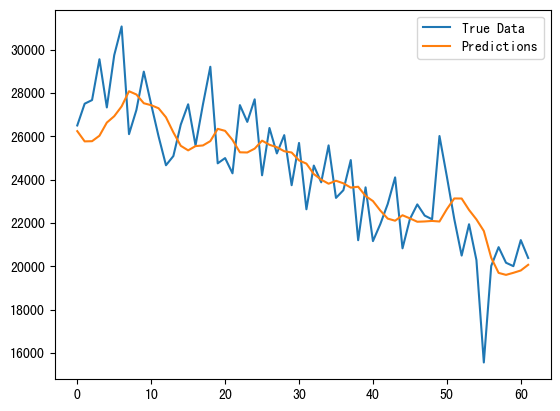

In [147]:
# 预测
model.eval()
with torch.no_grad():
    y_pred = model(X_test).squeeze()
    y_pred = scaler.inverse_transform(y_pred.numpy().reshape(-1, 1))
    y_true = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))

# 可视化
import matplotlib.pyplot as plt

plt.plot(y_true, label='True Data')
plt.plot(y_pred, label='Predictions')
plt.legend()
plt.show()


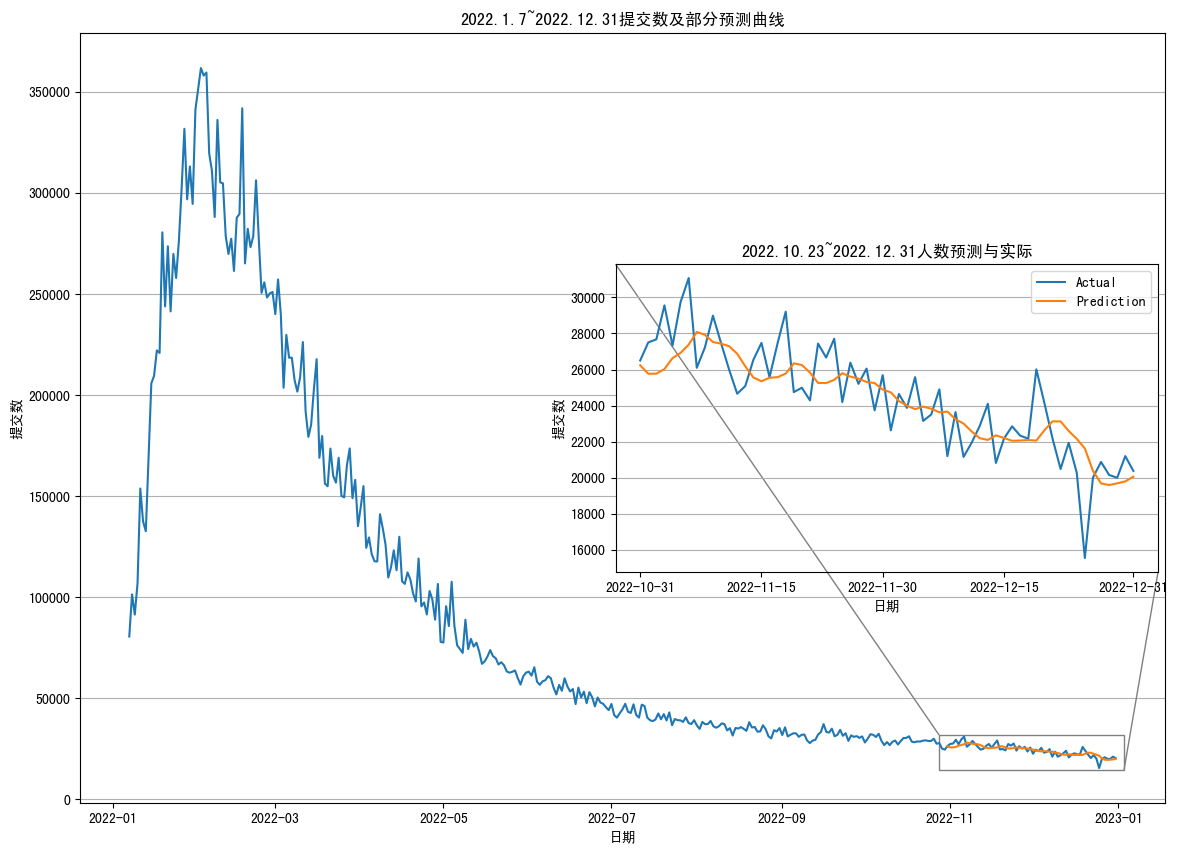

In [149]:
# 嵌套图部分
original_zoom = y_true
prediction_zoom = y_pred

# 创建主图
fig, ax = plt.subplots(figsize=(14, 10))
ax.plot(data[::-1]['Date'],data[::-1][features_tag[0]])
ax.plot(data[::-1][-62:]['Date'],y_pred, label='Predicted')
ax.set_xlabel('日期')
ax.set_ylabel('提交数')
plt.grid(axis= 'y')
ax.set_title('2022.1.7~2022.12.31提交数及部分预测曲线')

# 创建嵌套图
ax_inset = inset_axes(ax, width="50%", height="40%",loc = 'right')

ax_inset.plot(data[::-1][-62:]['Date'], original_zoom, label='Actual')
ax_inset.plot(data[::-1][-62:]['Date'], prediction_zoom, label='Prediction')
ax_inset.set_title('2022.10.23~2022.12.31人数预测与实际')
ax_inset.set_xlabel('日期')
ax_inset.set_ylabel('提交数')
plt.grid(axis= 'y')
plt.legend()

indices = np.linspace(0, 61, 5, dtype=int)  # 均匀选择 5 个索引
selected_dates = data[::-1][-62:]['Date'].iloc[indices]
ax_inset.set_xticks(selected_dates)

# 连接主图和嵌套图
mark_inset(ax, ax_inset, loc1=2, loc2=4, fc="none", ec="0.5")
plt.savefig('2022.1.7~2022.12.31提交数及部分预测曲线(GRU完整).png')
plt.show()

In [151]:
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
R2 = r2_score(y_true, y_pred)
print(f"MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {R2:.4f}")

MSE: 3221872.7500, RMSE: 1794.9576, MAE: 1405.9440, R2: 0.6344


In [153]:
data_to_pred = [] 
#通过2022.12.02~2022.12.31的数据预测2023.01.01的Reported Result
data_to_pred.append(np.array(Reported_Result_std[-30:]))
data_to_pred = torch.Tensor(data_to_pred)
with torch.no_grad():
    y_pred = model(data_to_pred).squeeze()
    y_pred = scaler.inverse_transform(y_pred.numpy().reshape(-1, 1))
Reported_Result_230101 = y_pred.flatten().tolist()[0]
print('预测为:',Reported_Result_230101)

预测为: 20896.5


/var/folders/y9/m9vnd4k96bl3q5jzh6gn3zww0000gn/T/ipykernel_1295/2255115141.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  data_to_pred = torch.Tensor(data_to_pred)


In [726]:
# 利用所有样本X进行预测,计算相对误差率
pred_x = []
temp_X = np.array(X)
temp_X = torch.Tensor(temp_X)
with torch.no_grad():
    y_pred = model(temp_X).squeeze()
    y_pred = scaler.inverse_transform(y_pred.numpy().reshape(-1, 1))
    pred_x = (y_pred.flatten().tolist())
print(len(pred_x))

349


In [728]:
temp_y = scaler.inverse_transform(y).flatten().tolist()
print(len(temp_y))

Relative_Error_Rate = np.abs(np.array(pred_x) - np.array(temp_y)) / np.abs(np.array(temp_y)) * 100
avg_Relative_Error_Rate = np.mean(Relative_Error_Rate)
print('相关误差率：',avg_Relative_Error_Rate,'%')
print('预测值范围',Reported_Result_230101,'+/-', avg_Relative_Error_Rate,'%')

349
相关误差率： 6.755180500692536 %
预测值范围 20646.7421875 +/- 6.755180500692536 %


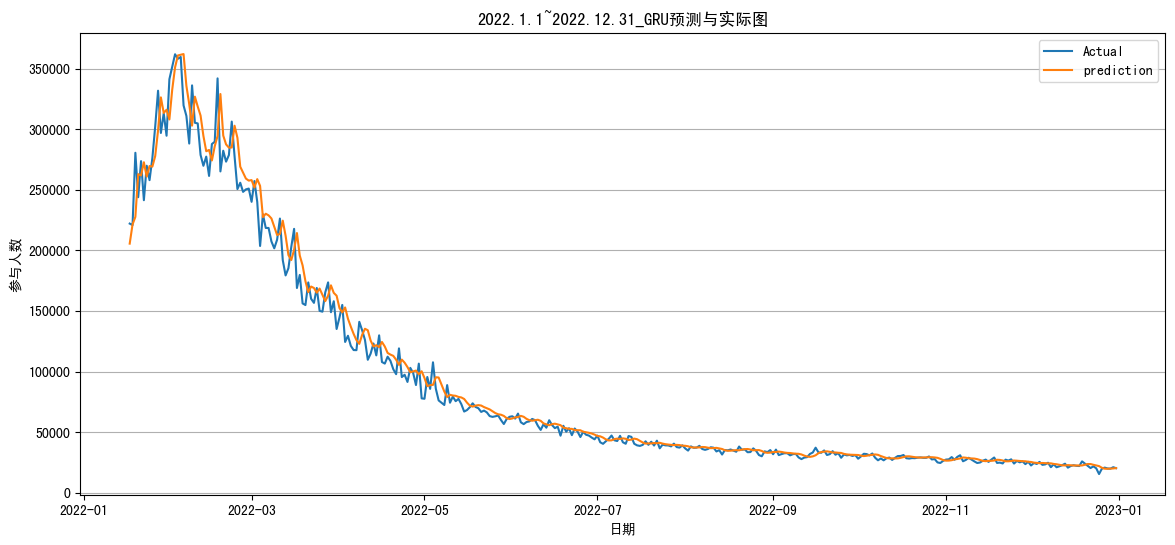

In [746]:
Date_GRU = data[::-1]['Date']
Date_GRU = Date_GRU[10:]
plt.figure(figsize = (14,6))
plt.plot(Date_GRU,temp_y,label = 'Actual')
plt.plot(Date_GRU,pred_x,label = 'prediction')
plt.title('2022.1.10~2022.12.31_GRU预测与实际图')
plt.xlabel('日期')
plt.ylabel('参与人数')
plt.legend()
plt.grid(axis= 'y')
plt.savefig('2022.1.10~2022.12.31_GRU预测与实际图.png')
plt.show()

In [121]:
#########################
##使用LSTM进行游玩人数预测##
#########################

scaler = MinMaxScaler(feature_range=(0, 1))
Reported_Result_Std_LSTM = scaler.fit_transform(Reported_Result.reshape(-1, 1))

In [123]:
# 构造监督学习数据
def create_sequences_LSTM(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps])
        y.append(data[i + n_steps])
    return np.array(X), np.array(y)

n_steps = 10  # 时间步数
X, y = create_sequences_LSTM(Reported_Result_Std_LSTM, n_steps)

# 重塑数据为LSTM输入格式 [样本数, 时间步数, 特征数]
X = X.reshape((X.shape[0], X.shape[1], 1))

# 3. 划分训练集和测试集
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 4. 构建LSTM模型
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 5. 训练模型
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)


Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1177 - val_loss: 1.2113e-04
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0765 - val_loss: 0.0021
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0501 - val_loss: 0.0081
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0192 - val_loss: 0.0111
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0068 - val_loss: 5.3445e-04
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0043 - val_loss: 5.5946e-05
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0025 - val_loss: 3.1548e-05
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0024 - val_loss: 8.6141e-04
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0028 - val_loss: 2.0422e-04
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0021 - val_loss: 4.9371e-04
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0027 - val_loss: 5.9606e-05
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0023 - val_loss

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


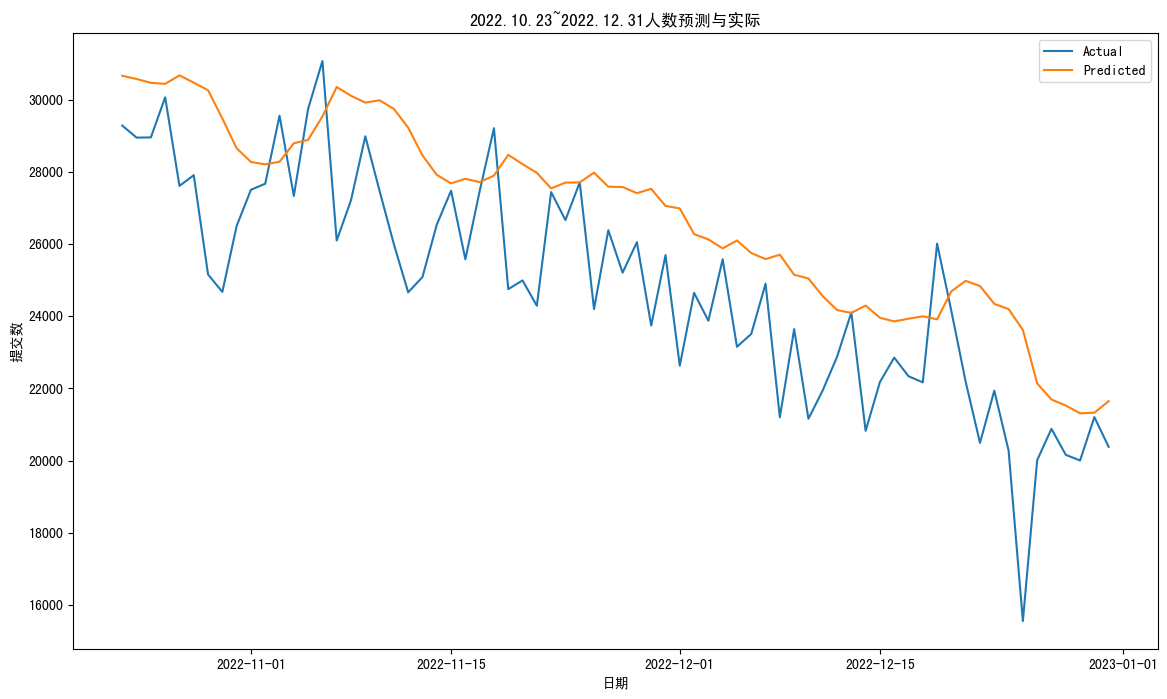

In [125]:
# 6. 预测
# 使用测试集进行预测
y_pred = model.predict(X_test)

# 反归一化预测结果
y_pred = scaler.inverse_transform(y_pred)
y_test_actual = scaler.inverse_transform(y_test)

# 7. 可视化结果
plt.figure(figsize = (14,8))
plt.plot(data[::-1][-70:]['Date'],y_test_actual[-70:], label='Actual')
plt.plot(data[::-1][-70:]['Date'],y_pred[-70:], label='Predicted')
plt.legend()
plt.xlabel('日期')
plt.ylabel('提交数')
plt.title('2022.10.23~2022.12.31人数预测与实际')
plt.savefig('2022.10.23~2022.12.31_reported_and_actual.png')
plt.show()


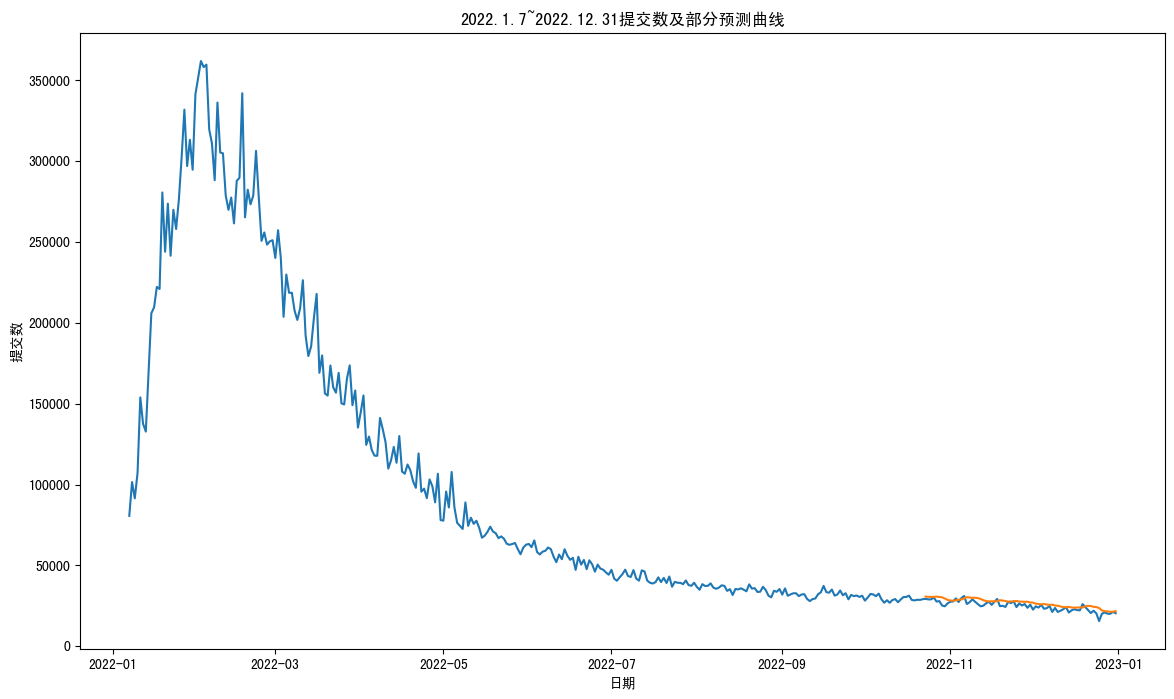

In [127]:
plt.figure(figsize = (14,8))
plt.plot(data[::-1]['Date'],data[::-1][features_tag[0]])
plt.plot(data[::-1][-70:]['Date'],y_pred[-70:], label='Predicted')
plt.title('2022.1.7~2022.12.31提交数及部分预测曲线')
plt.xlabel('日期')
plt.ylabel('提交数')
plt.savefig('2022.1.7~2022.12.31_total_report_and_predicted.png')
plt.show()

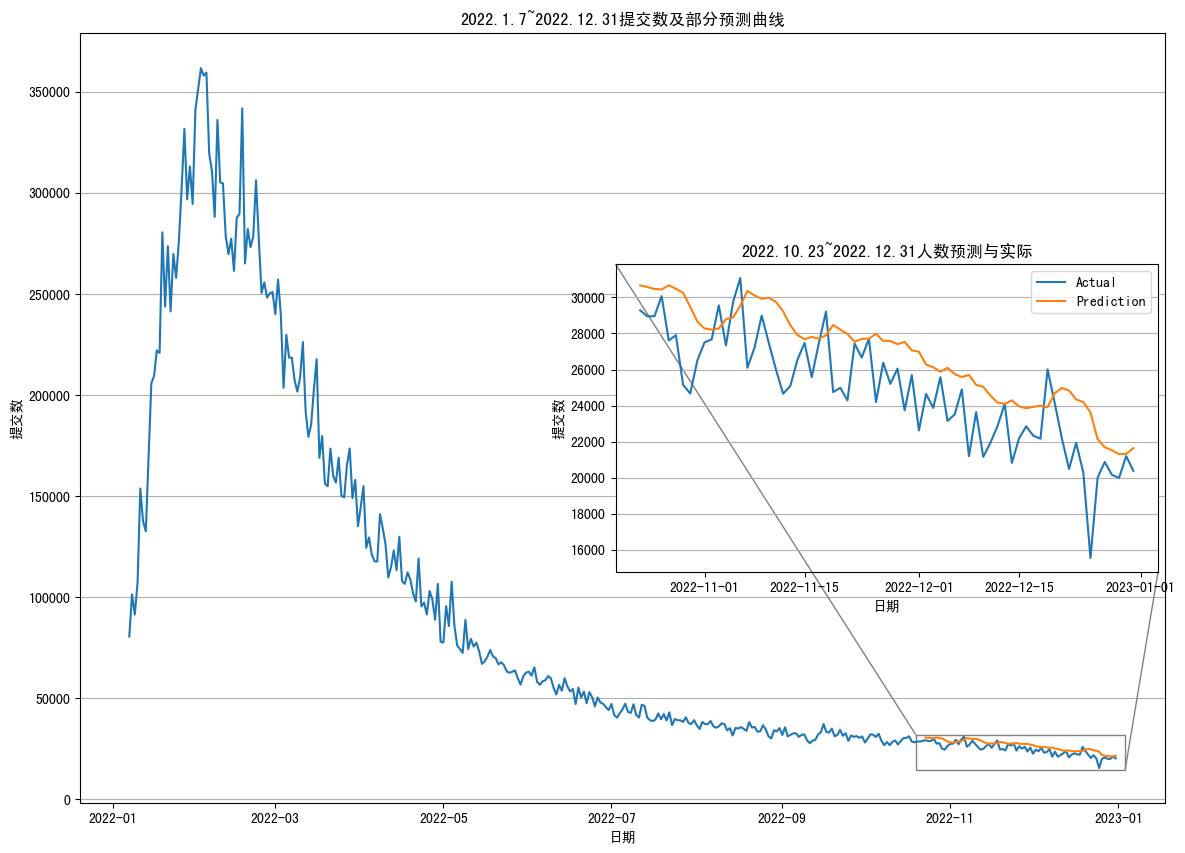

In [129]:

# 嵌套图部分
original_zoom = y_test_actual[-70:]
prediction_zoom = y_pred[-70:]

# 创建主图
fig, ax = plt.subplots(figsize=(14, 10))
ax.plot(data[::-1]['Date'],data[::-1][features_tag[0]])
ax.plot(data[::-1][-70:]['Date'],y_pred, label='Predicted')
ax.set_xlabel('日期')
ax.set_ylabel('提交数')
ax.set_title('2022.1.7~2022.12.31提交数及部分预测曲线')
plt.grid(axis= 'y')

# 创建嵌套图
ax_inset = inset_axes(ax, width="50%", height="40%",loc = 'right')

ax_inset.plot(data[::-1][-70:]['Date'], original_zoom, label='Actual')
ax_inset.plot(data[::-1][-70:]['Date'], prediction_zoom, label='Prediction')
ax_inset.set_title('2022.10.23~2022.12.31人数预测与实际')
ax_inset.set_xlabel('日期')
ax_inset.set_ylabel('提交数')
plt.legend()
plt.grid(axis= 'y')

# 连接主图和嵌套图
mark_inset(ax, ax_inset, loc1=2, loc2=4, fc="none", ec="0.5")
plt.savefig('2022.1.7~2022.12.31提交数及部分预测曲线(LSTM完整).png')
plt.show()

In [131]:
######################
## MSE RMSE MAE R^2 ##
######################
mse = mean_squared_error(y_test_actual, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, y_pred)
R2 = r2_score(y_test_actual, y_pred)
print(f"MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {R2:.4f}")


MSE: 6977765.9019, RMSE: 2641.5461, MAE: 2162.4402, R2: 0.2536


In [133]:
print(np.max(y_test_actual))
rmse/np.max(y_test_actual)

31068.0


0.08502465944319652

In [364]:
# 发现2022.12.25数据异常
# no_2022_12_25_actual = []
# no_2022_12_25_actual = y_test_actual[:-7]
# no_2022_12_25_actual.extend(y_test_actual[-8:])

# no_2022_11_30_actual = []
# no_2022_11_30_actual = y_test_actual[:-32].ravel().tolist()
# no_2022_11_30_actual = no_2022_11_30_actual + y_test_actual[-31:].ravel().tolist()

# no_2022_11_30_pred = []
# no_2022_11_30_pred = y_pred[:-32].ravel().tolist()
# no_2022_11_30_pred = no_2022_11_30_pred + y_pred[-31:].ravel().tolist()

In [406]:
# mse = mean_squared_error(no_2022_11_30_actual, no_2022_11_30_pred)
# rmse = np.sqrt(mse)
# mae = mean_absolute_error(no_2022_11_30_actual, no_2022_11_30_pred)
# R2 = r2_score(no_2022_11_30_actual, no_2022_11_30_pred)
# print(f"MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {R2:.4f}")

In [798]:
len(y_pred_all)

349

In [135]:
# 使用测试集进行预测
y_pred_all = model.predict(X)
Date_LSTM = Date_GRU
# 反归一化预测结果
plt.figure(figsize = (14,6))
y_pred_all = scaler.inverse_transform(y_pred_all)
y_true_all = data[::-1][features_tag[0]].tolist()
plt.plot(Date_LSTM,y_true_all[10:],label = 'Actual')
plt.plot(Date_LSTM,y_pred_all,label = 'Prediction')
plt.legend()
plt.grid(axis = 'y')
plt.title('2022.1.10~2022.12.31_LSTM预测与实际图')
plt.savefig('2022.1.10~2022.12.31_LSTM预测与实际图.png')
plt.show()
# plt.plot(y_pred_all)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


NameError: name 'Date_GRU' is not defined

In [137]:
Relative_Error_Rate = np.abs(np.array(y_pred_all) - np.array(y_true_all[10:])) / np.abs(y_true_all[10:]) * 100
avg_Relative_Error_Rate_LSTM = np.mean(Relative_Error_Rate)
print('相关误差率：',avg_Relative_Error_Rate_LSTM,'%')
print('预测值范围',Reported_Result_230101,'+/-', avg_Relative_Error_Rate,'%')

NameError: name 'y_true_all' is not defined

In [15]:
##################################
## 根据尝试次数获得得分情况：score ##
##################################
data = pd.read_excel("Problem_C_Data_Wordle_new.xlsx")

scores = []

w1 = w2 = 0.5



try_percent = features[['1 try','2 tries','3 tries','4 tries','5 tries','6 tries','7 or more tries (X)']]

print(try_percent.iloc[0].values)

for i in range(len(try_percent)):
    score_1 = score_2 = 0
    for j in range(6):
        score_1 = score_1 + (j+1)*try_percent.iloc[i].values[j]
    score_2 = w2*try_percent.iloc[i].values[6]
    scores.append(w1*score_1+score_2)
scores = np.array(scores)
scores = scores / 100
print(scores)
# score = 0.5*()



[ 0  2 17 37 29 12  2]
[2.11  2.04  2.14  2.045 2.135 2.17  2.06  1.83  1.975 2.195 1.875 1.735
 1.685 1.945 1.83  2.005 1.97  2.09  1.91  1.995 2.01  2.08  1.78  2.06
 1.95  2.025 2.28  1.77  1.895 1.925 2.215 1.955 2.14  1.785 1.92  1.725
 1.905 1.855 1.84  1.935 2.075 2.1   1.985 2.    1.795 2.06  2.055 1.945
 1.985 2.03  2.005 1.845 1.725 2.015 1.96  1.755 1.71  1.885 1.75  1.975
 2.215 2.03  2.225 2.185 1.95  2.045 1.96  2.18  1.97  2.225 1.93  2.135
 1.935 2.035 1.99  1.83  1.9   1.71  2.035 2.06  2.1   1.99  2.23  2.185
 2.15  2.145 1.77  1.9   2.09  1.915 1.935 2.1   1.93  2.045 2.03  2.09
 1.97  1.95  1.795 1.915 1.78  1.97  2.065 1.925 1.805 1.775 1.555 1.805
 1.96  2.09  2.315 2.14  2.085 1.885 1.97  2.095 1.935 2.13  1.975 2.245
 1.84  2.085 2.235 1.985 1.905 2.23  2.145 1.945 1.925 2.08  2.18  1.88
 2.035 1.73  2.06  2.06  1.955 2.095 2.105 2.135 2.155 2.135 1.99  2.095
 2.13  2.05  2.135 1.725 2.26  2.02  2.12  2.225 2.085 1.92  2.15  1.945
 1.965 2.22  2.09  2.06  2.005 

In [185]:
data['scores'] = scores

In [217]:

Words = data['Word']
f_Word = [] # 单词在现实中的使用频率
for i in range(len(Words)):
    f_Word.append(word_frequency(Words.iloc[i], 'en'))
f_Word = np.array(f_Word)
data['f_Word'] = f_Word
print(Words[87])
f_Word[87]

march


0.000182

In [19]:
f_Word_log10 = np.log10(f_Word)

###################################
if(np.where(f_Word == 0)[0].shape[0] != 0):
    index = np.where(f_Word == 0)[0]
    print(index)
    data[index[0],'Word'] = 'march'
    print(data['Word'][index[0]])
    
    f_Word = [] # 单词在现实中的使用频率
    for i in range(len(Words)):
        f_Word.append(word_frequency(Words.iloc[i], 'en'))
#####################################

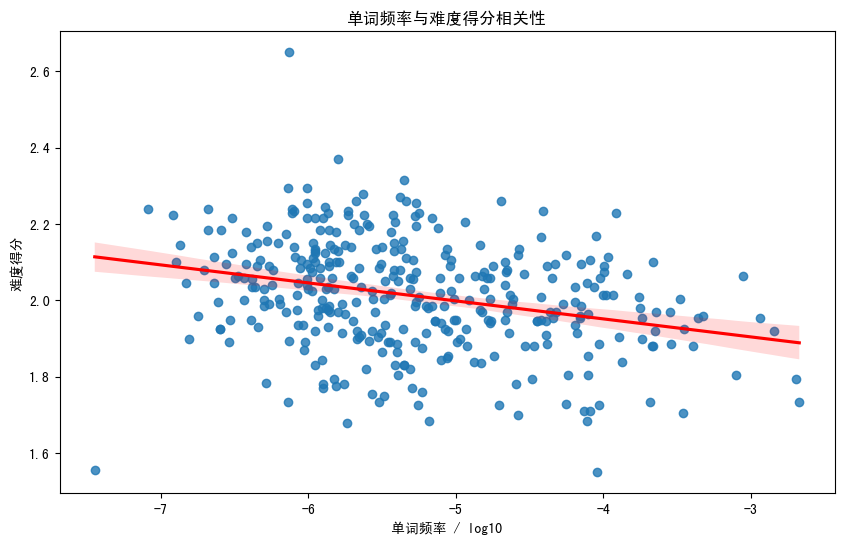

In [27]:
f_Word_log10 = f_Word_log10.tolist()

f_Word_log10_scores = pd.DataFrame({
    'f_Word_log10': f_Word_log10,
    'scores': scores
})

plt.figure(figsize=(10, 6))
sns.regplot(x='f_Word_log10', y='scores', data=f_Word_log10_scores, 
            scatter=True,  # 显示散点
            ci=95,         # 95% 置信区间
            line_kws={'color': 'red'},  # 回归线颜色
            )  # 散点透明度
plt.title("单词频率与难度得分相关性")

plt.xlabel("单词频率 / log10")
plt.ylabel("难度得分")
plt.savefig('单词频率与难度得分相关性.png')
plt.show()

In [900]:

# f_Word_log10 = f_Word_log10.tolist()
# # 绘制散点图
# plt.scatter(f_Word_log10,scores)

# # 设置图形标题和轴标签
# plt.title("单词频率与难度得分")

# plt.xlabel("单词频率 / log10")
# plt.ylabel("难度得分")
# # 显示图形
# plt.show()

In [47]:

# 计算皮尔森相关系数和 p 值
pearson_corr, p_value = pearsonr(f_Word_log10, scores)

print(f"皮尔森相关系数: {pearson_corr} p值：{p_value}")

# 计算斯皮尔曼相关系数和 p 值
spearman_corr, p_value = spearmanr(f_Word_log10, scores)

print(f"斯皮尔曼相关系数: {spearman_corr},p 值: {p_value}")

皮尔森相关系数: -0.29024899346254673 p值：2.1276369492319706e-08
斯皮尔曼相关系数: -0.3012846304738087,p 值: 5.728085341600872e-09


In [219]:
letter_f = np.array([8.2,1.5,2.8,4.3,12.7,2.2,2,6.1,7,0.15,0.77,4,2.4,6.7,7.5,1.9,0.095,6.0,6.3,9.1,2.8,0.98,2.4,0.15,2,0.074])/100
## 方案一:
# 假设对于连续出现的字母采用相加的方法,其余采用相乘，这个值定义为字母的频率,如app,a是8.2,p是1.9,那么app的f_letter = 8.2/100 * ( 1.9/100 * 2) = 0.12

# from collections import Counter

# f_letters = []
# for word in Words:
#     # 统计字母出现次数
#     f_letter = 1
#     letter_count = Counter(word)

#     # 输出结果
#     for letter, count in letter_count.items():
#         f_letter = f_letter * letter_f[(ord(letter)-97)] * count
#     f_letters.append(f_letter)

# 方案二: 不管重复,全部采用权重相加
f_letters = []
for word in Words:
    f_letter = 0;
    for i in range(len(word)):
        f_letter = f_letter + letter_f[ord(word[i])-97]
    f_letters.append(f_letter)
f_letters = np.array(f_letters)
data['f_letters'] = f_letters
print(f_letters)
print(len(f_letters))

[0.233   0.281   0.2558  0.28    0.288   0.2195  0.3615  0.354   0.39
 0.3235  0.277   0.325   0.403   0.379   0.267   0.296   0.2618  0.241
 0.2917  0.18    0.3558  0.1854  0.27    0.346   0.2585  0.308   0.3007
 0.387   0.364   0.32    0.3745  0.245   0.293   0.35    0.201   0.344
 0.27    0.385   0.3098  0.3     0.2525  0.2938  0.3698  0.16    0.466
 0.2917  0.312   0.292   0.413   0.3498  0.316   0.383   0.299   0.289
 0.299   0.403   0.336   0.321   0.268   0.374   0.303   0.252   0.23774
 0.292   0.3467  0.25    0.256   0.157   0.263   0.12    0.319   0.2918
 0.331   0.16665 0.3525  0.418   0.334   0.29    0.272   0.27795 0.31
 0.2448  0.2905  0.223   0.2348  0.255   0.33    0.255   0.199   0.311
 0.379   0.3858  0.293   0.256   0.198   0.198   0.2157  0.31    0.38
 0.215   0.373   0.316   0.3267  0.376   0.2597  0.335   0.348   0.252
 0.323   0.284   0.29274 0.328   0.248   0.43    0.276   0.374   0.359
 0.254   0.415   0.148   0.255   0.207   0.27674 0.423   0.308   0.25774
 0.

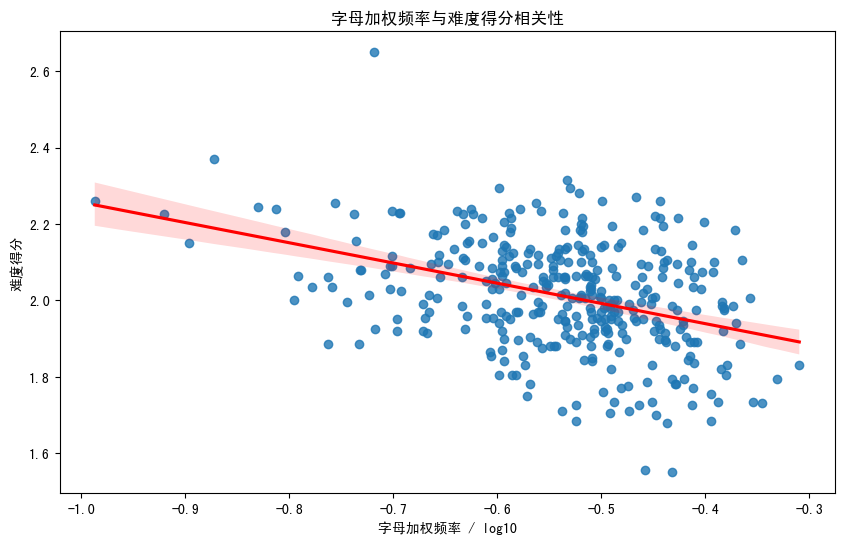

In [51]:
f_letters_log10 = np.log10(f_letters)
f_letters_log10 = f_letters_log10.tolist()
f_letters_log10_scores = pd.DataFrame({
    'f_letters_log10': f_letters_log10,
    'scores': scores
})

# 3. 使用 regplot 绘制散点图和回归线
plt.figure(figsize=(10, 6))
sns.regplot(x='f_letters_log10', y='scores', data=f_letters_log10_scores, 
            scatter=True,  # 显示散点
            ci=95,         # 95% 置信区间
            line_kws={'color': 'red'},  # 回归线颜色
            )  # 散点透明度
plt.title("字母加权频率与难度得分相关性")

plt.xlabel("字母加权频率 / log10")
plt.ylabel("难度得分")
plt.savefig('字母加权频率与难度得分相关性.png')
plt.show()

In [912]:
# f_letters_log10 = np.log10(f_letters)
# # 绘制散点图

# plt.scatter(f_letters_log10,scores)

# # 设置图形标题和轴标签
# plt.title("association between frequence of letter and Score of word")

# plt.xlabel("frequence of letter / log10")
# plt.ylabel("Score of word")
# # 显示图形
# plt.show()

In [914]:
# 计算皮尔森相关系数和 p 值
pearson_corr, p_value = pearsonr(f_letters_log10, scores)

print(f"皮尔森相关系数: {pearson_corr} p值：{p_value}")

# 计算斯皮尔曼相关系数和 p 值
spearman_corr, p_value = spearmanr(f_letters_log10, scores)

print(f"斯皮尔曼相关系数: {spearman_corr},p 值: {p_value}")

皮尔森相关系数: -0.3828899579491171 p值：5.5688629085065454e-14
斯皮尔曼相关系数: -0.35355027901998765,p 值: 5.2166342431475645e-12


In [31]:
def has_duplicate_letters(s):
    # 如果集合长度小于字符串长度，说明有重复字母
    return 1 if len(set(s)) < len(s) else 0
isRepeatLetter = []
for word in Words:
    isRepeatLetter.append(has_duplicate_letters(word))
isRepeatLetter = np.array(isRepeatLetter)



/var/folders/y9/m9vnd4k96bl3q5jzh6gn3zww0000gn/T/ipykernel_1295/1302219470.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(repetition_box_plot_data, labels=["单词内有重复字母", "单词内没有重复字母"])


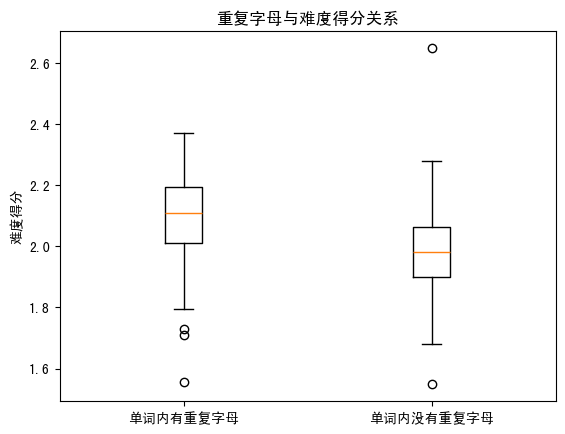

In [37]:

# 示例多组数据
repetition_box_plot_data = [
    scores[isRepeatLetter == 1],
    scores[isRepeatLetter == 0]
]

# 绘制多组箱型图
plt.boxplot(repetition_box_plot_data, labels=["单词内有重复字母", "单词内没有重复字母"])

# 添加标题和标签
plt.title("重复字母与难度得分关系")
plt.ylabel("难度得分")
plt.savefig('重复字母与难度得分关系.png')
# 显示图形
plt.show()

In [43]:
# 计算median difference
median_with_rep = np.median(repetition_box_plot_data[0])
median_without_rep = np.median(repetition_box_plot_data[1])

median_difference = median_with_rep - median_without_rep
print('中位数之差：',median_difference)

# 计算Box length difference
q1_1, q3_1 = np.percentile(median_with_rep, [25, 75])  # Q1 和 Q3
q1_2, q3_2 = np.percentile(median_without_rep, [25, 75])

box_difference = (q3_1 - q1_1) - (q3_2 - q1_2)
print('箱体长度之差：',box_difference)

中位数之差： 0.13000000000000034
箱体长度之差： 0.0


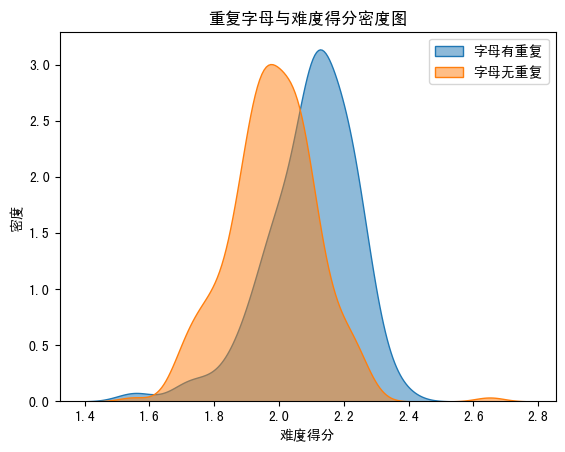

In [41]:
# 绘制密度图
sns.kdeplot(repetition_box_plot_data[0], label='字母有重复', fill=True, alpha=0.5)
sns.kdeplot(repetition_box_plot_data[1], label='字母无重复', fill=True, alpha=0.5)

# 添加标题和图例
plt.title("重复字母与难度得分密度图")
plt.xlabel("难度得分")
plt.ylabel("密度")
plt.legend()
plt.savefig('重复字母与难度得分密度图.png')
plt.show()

In [55]:
#训练数据准备
# f_Word = np.array(f_Word)
# f_letters_log10 = np.log10(f_letters)
# f_Word_log10 = np.log10(f_Word)
# print('字母频率:',f_letters_log10.shape,'长度:',len(f_letters))
# print('单词使用频率:',f_Word_log10.shape,'长度:',len(f_Word))
# print('单词是否重复:',isRepeatLetter.shape,'长度:',len(isRepeatLetter))
# print('尝试次数:',try_percent.shape,'长度:',len(try_percent))

# GSRF_data = pd.DataFrame({"word_freq":f_Word_log10,
#             "letter_freq":f_letters_log10 ,
#              'isRepeatLetter':isRepeatLetter,
#             })

# GSRF_data = GSRF_data.to_numpy()

# GSRF_data_try = try_percent.to_numpy()
# print(GSRF_data_try)

字母频率: (359,) 长度: 359
单词使用频率: (359,) 长度: 359
单词是否重复: (359,) 长度: 359
尝试次数: (359, 7) 长度: 359
[[ 0  2 17 ... 29 12  2]
 [ 0  4 21 ... 26  9  1]
 [ 0  2 16 ... 30 12  2]
 ...
 [ 1  3 13 ... 30 22  4]
 [ 1  5 23 ... 24 14  2]
 [ 1  3 23 ... 24  9  1]]


In [163]:
# GSRF Prediction Model

# 训练数据准备
f_Word = np.array(f_Word)
print('字母频率:',f_letters.shape,'长度:',len(f_letters))
print('单词使用频率:',f_Word.shape,'长度:',len(f_Word))
print('单词是否重复:',isRepeatLetter.shape,'长度:',len(isRepeatLetter))
print('尝试次数:',try_percent.shape,'长度:',len(try_percent))


print(try_percent.shape)

GSRF_data = pd.DataFrame({"word_freq":f_Word,
            "letter_freq":f_letters ,
             'isRepeatLetter':isRepeatLetter,
            })

GSRF_data = GSRF_data.to_numpy()

GSRF_data_try = try_percent.to_numpy()
print(GSRF_data_try)

字母频率: (359,) 长度: 359
单词使用频率: (359,) 长度: 359
单词是否重复: (359,) 长度: 359
尝试次数: (359, 7) 长度: 359
(359, 7)
[[ 0  2 17 ... 29 12  2]
 [ 0  4 21 ... 26  9  1]
 [ 0  2 16 ... 30 12  2]
 ...
 [ 1  3 13 ... 30 22  4]
 [ 1  5 23 ... 24 14  2]
 [ 1  3 23 ... 24  9  1]]


In [165]:
# 准备训练集
X_train, X_test, y_train, y_test = train_test_split(GSRF_data, try_percent, test_size=0.2, random_state=42)

print(X_test)


[[7.9400e-06 2.5200e-01 0.0000e+00]
 [1.3800e-06 3.6980e-01 0.0000e+00]
 [2.1400e-03 4.0900e-01 0.0000e+00]
 [1.0200e-04 3.9500e-01 1.0000e+00]
 [8.1300e-05 3.3600e-01 0.0000e+00]
 [2.0400e-05 3.6000e-01 1.0000e+00]
 [9.7700e-06 2.9600e-01 0.0000e+00]
 [9.3300e-05 3.2100e-01 1.0000e+00]
 [7.9400e-05 2.9000e-01 0.0000e+00]
 [1.2900e-04 3.0800e-01 0.0000e+00]
 [1.2300e-04 2.9050e-01 0.0000e+00]
 [3.8000e-05 2.4880e-01 0.0000e+00]
 [5.6200e-07 3.0900e-01 0.0000e+00]
 [2.9500e-05 2.8500e-01 0.0000e+00]
 [1.2900e-06 1.4800e-01 1.0000e+00]
 [1.3500e-07 3.1800e-01 1.0000e+00]
 [6.9200e-06 3.6000e-01 1.0000e+00]
 [1.0700e-05 2.9500e-01 0.0000e+00]
 [1.1000e-06 2.2840e-01 1.0000e+00]
 [4.3700e-06 2.3595e-01 0.0000e+00]
 [5.2500e-07 1.8370e-01 0.0000e+00]
 [2.0900e-06 3.4500e-01 0.0000e+00]
 [1.0700e-06 2.8300e-01 0.0000e+00]
 [5.1300e-07 3.5000e-01 0.0000e+00]
 [1.7800e-04 3.1800e-01 0.0000e+00]
 [1.3500e-06 2.0180e-01 0.0000e+00]
 [1.9500e-05 3.8600e-01 0.0000e+00]
 [1.0000e-05 3.1900e-01 0.00

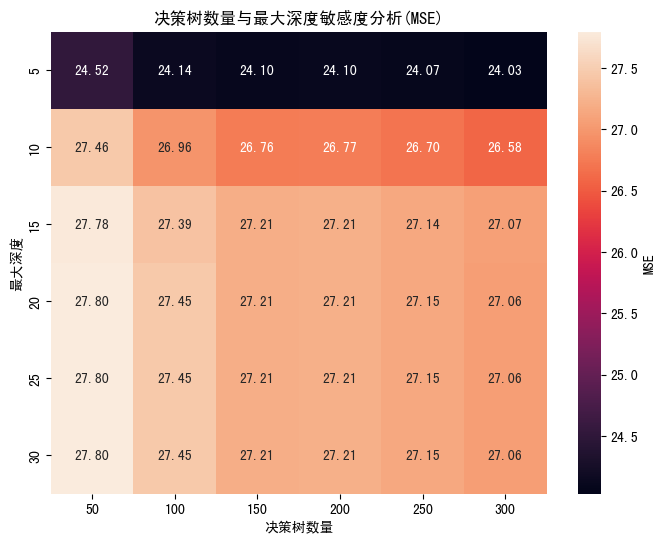

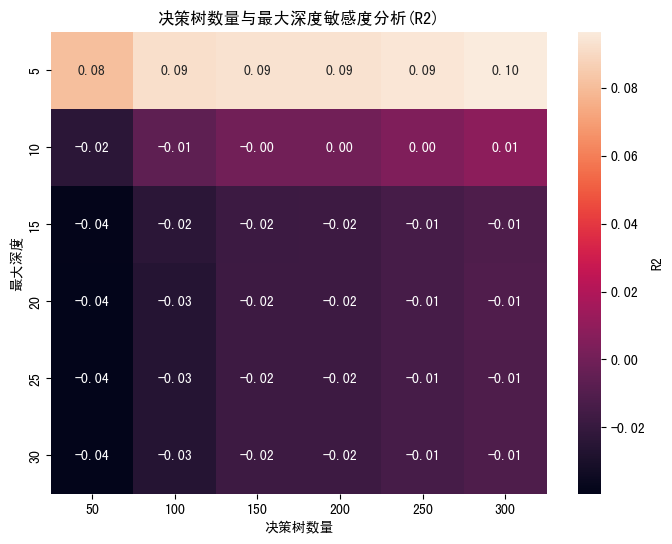

In [119]:
#######################
## 随机森林超参数敏感度 ##
#######################

# 定义超参数网格
param_grid = {
    'n_estimators': [50,100,150,200,250,300],
    'max_depth': [5,10,15,20,25,30]
}
rf = RandomForestRegressor(random_state=45,min_samples_split = 2)

# 使用MSE
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# 提取结果
results = grid_search.cv_results_
n_estimators = param_grid['n_estimators']
max_depth = param_grid['max_depth']
mse_scores = -np.array(results['mean_test_score']).reshape(len(max_depth), len(n_estimators))

# 绘制热力图
plt.figure(figsize=(8, 6))
sns.heatmap(mse_scores, annot=True, fmt='.2f', xticklabels=n_estimators, yticklabels=max_depth,
             cbar_kws={'label': 'MSE'})
plt.xlabel('决策树数量')
plt.ylabel('最大深度')
plt.title('决策树数量与最大深度敏感度分析(MSE)')
plt.savefig('决策树数量与最大深度敏感度分析(MSE).png')

plt.show()

############################################################

#使用R2
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='r2')
grid_search.fit(X_train, y_train)

results = grid_search.cv_results_
n_estimators = param_grid['n_estimators']
max_depth = param_grid['max_depth']

r2_scores = np.array(results['mean_test_score']).reshape(len(max_depth), len(n_estimators))

plt.figure(figsize=(8, 6))
sns.heatmap(r2_scores, annot=True, fmt='.2f', xticklabels=n_estimators, yticklabels=max_depth,
             cbar_kws={'label': 'R2'})
plt.xlabel('决策树数量')
plt.ylabel('最大深度')
plt.title('决策树数量与最大深度敏感度分析(R2)')
plt.savefig('决策树数量与最大深度敏感度分析(R2).png')
plt.show()

In [167]:
# 定义随机森林模型
rf = RandomForestRegressor(random_state=42)

# 定义网格搜索的参数范围
param_grid = {
    "n_estimators": [100, 200, 300], # 表示森林中包含的决策树数量，越多的树可以提高模型的稳定性和准确性，但计算开销也会增加
    "max_depth": [10, 20,30, None], # 限制每棵树的深度，控制模型的复杂度。
    "min_samples_split": [2, 5, 10,15,20], # 内部节点再分裂所需的最小样本数 控制分裂一个节点所需的最小样本数，限制树的生长
    "min_samples_leaf": [1, 2, 4,8] # 叶子节点所需的最小样本数 控制每个叶子节点的最小样本数，防止树过度生长
}

# 定义网格搜索
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",  # 使用均方误差作为评价指标
    cv=3,  # 3折交叉验证
    verbose=2,
    n_jobs=-1  # 使用所有可用CPU
)

# 执行网格搜索
grid_search.fit(X_train, y_train)

# 最优参数
print("Best Parameters:", grid_search.best_params_)

# 使用最优参数训练的模型
best_rf = grid_search.best_estimator_

# 在测试集上预测
y_pred = best_rf.predict(X_test)

# 评估模型性能
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")


# 输出 R^2
r2 = best_rf.score(X_test, y_test)
print(f"R^2 Score: {r2:.2f}")

Fitting 3 folds for each of 240 candidates, totalling 720 fits
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 20, 'n_estimators': 200}
Mean Squared Error: 24.91
R^2 Score: 0.17


In [169]:
print(f"RMSE: {np.sqrt(mse):.2f}")

RMSE: 4.99


In [171]:
eerie_f =word_frequency('eerie','en') #eerie的使用频率
eerie_letter_f = 0

for i in range(len('eerie')):
    eerie_letter_f = eerie_letter_f + letter_f[ord('eerie'[i])-97]
        
print(eerie_f)

print(eerie_letter_f)

eerie_pred_try = [eerie_f,eerie_letter_f,1]

print(eerie_pred_try)

eerie_pred_try = np.array(eerie_pred_try).reshape(1,-1)
print(eerie_pred_try)

try_pred = best_rf.predict(eerie_pred_try)
try_pred = try_pred.reshape(-1)
print('预测结果:',try_pred.reshape(-1))

2.14e-06
0.511
[2.14e-06, 0.511, 1]
[[2.14e-06 5.11e-01 1.00e+00]]
预测结果: [ 0.45739252 10.20620773 26.68408788 31.37112265 20.16421145  9.27872807
  2.18509696]


In [173]:
try_percent

,1 try,2 tries,3 tries,4 tries,5 tries,6 tries,7 or more tries (X)
0,0,2,17,37,29,12,2
1,0,4,21,38,26,9,1
2,0,2,16,38,30,12,2
3,0,3,21,40,25,9,1
4,0,2,17,35,29,14,3
...,...,...,...,...,...,...,...
354,1,9,35,34,16,5,1
355,1,4,16,30,30,17,2
356,1,3,13,27,30,22,4
357,1,5,23,31,24,14,2


In [197]:
data

,Unnamed: 0,Date,Contest number,Word,Number of reported results,Number in hard mode,1 try,2 tries,3 tries,4 tries,5 tries,6 tries,7 or more tries (X),"(87, 'Word')",clusters,scores
0,0,2022-12-31,560,manly,20380,1899,0,2,17,37,29,12,2,march,1,2.110
1,1,2022-12-30,559,molar,21204,1973,0,4,21,38,26,9,1,march,1,2.040
2,2,2022-12-29,558,havoc,20001,1919,0,2,16,38,30,12,2,march,1,2.140
3,3,2022-12-28,557,impel,20160,1937,0,3,21,40,25,9,1,march,1,2.045
4,4,2022-12-27,556,condo,20879,2012,0,2,17,35,29,14,3,march,1,2.135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,354,2022-01-11,206,drink,153880,3017,1,9,35,34,16,5,1,march,0,1.855
355,355,2022-01-10,205,query,107134,2242,1,4,16,30,30,17,2,march,1,2.155
356,356,2022-01-09,204,gorge,91477,1913,1,3,13,27,30,22,4,march,2,2.200
357,357,2022-01-08,203,crank,101503,1763,1,5,23,31,24,14,2,march,1,2.050


In [261]:
kmeans_features = data[['1 try','2 tries','3 tries','4 tries','5 tries','6 tries','7 or more tries (X)']]
# kmeans_features = data[['scores','f_Word','f_letters']]


[1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 1 0 1 0 0 1 1 0 1 0 1 2 0 0 0 1 0 1 0 0 0 0
 0 0 0 1 2 0 1 0 2 1 0 1 1 1 0 0 1 0 0 0 0 0 0 1 1 2 1 0 1 0 1 0 2 0 1 0 1
 1 0 0 2 1 1 2 0 2 2 1 2 0 0 1 0 0 1 0 1 1 1 1 0 0 0 0 0 1 2 0 0 2 0 1 1 2
 1 1 0 1 1 2 1 1 2 0 1 2 0 0 2 1 0 0 1 2 0 2 0 1 1 0 1 2 1 2 1 1 1 1 1 1 0
 2 1 1 2 1 0 1 0 0 1 2 1 1 1 1 1 2 0 1 1 1 2 2 0 0 1 1 1 1 1 2 1 2 1 1 1 2
 2 1 1 0 1 1 1 1 1 0 0 2 1 0 1 0 1 0 2 1 1 1 1 1 0 1 0 1 1 0 0 1 0 0 0 2 1
 1 0 0 2 1 0 1 1 2 0 0 1 0 1 0 2 1 1 2 0 1 1 2 2 0 2 0 0 2 0 1 0 2 1 2 0 1
 1 1 1 0 1 1 0 0 0 2 2 2 1 2 0 2 2 2 1 2 1 2 0 0 1 1 0 1 1 0 1 2 0 1 1 0 2
 0 1 1 0 0 0 1 0 0 1 0 0 1 2 1 2 0 0 1 2 2 2 1 1 1 0 1 1 0 1 2 2 1 1 0 1 0
 0 0 1 0 1 0 1 1 2 0 1 0 0 0 2 0 0 0 1 2 2 0 1 2 1 1]


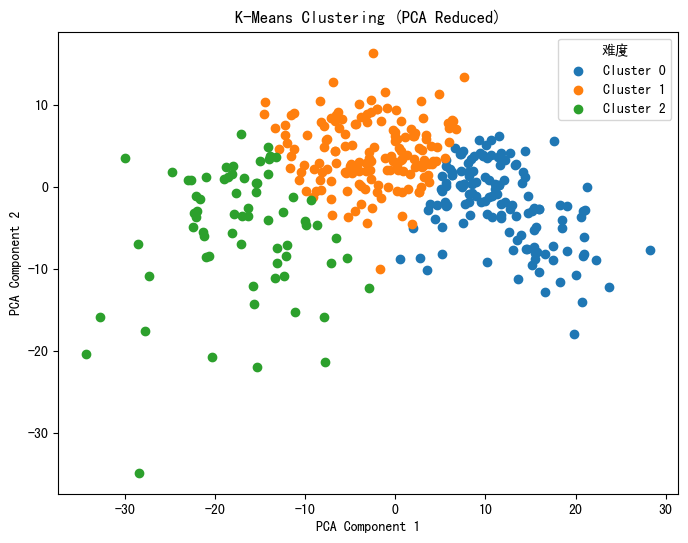

In [397]:
# K-Means对单词聚合为3类

# 设置聚类模型
kmeans = KMeans(n_clusters=3, init="k-means++")

# 拟合模型
# kmeans.fit(try_percent)
kmeans.fit(kmeans_features)
# kmeans.fit(scores)

# 获取聚类结果
labels = kmeans.labels_ # 每个样本的类别标签
centroids = kmeans.cluster_centers_  # 每个簇的中心点
data['clusters'] = labels

# 将结果添加到 DataFrame 中
print(labels)

# 使用 PCA 将数据降为 2 维
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(try_percent)
# 绘制聚类结果
plt.figure(figsize=(8, 6))
for i in range(3):  # 3 个类别
    plt.scatter(reduced_data[labels == i, 0], reduced_data[labels == i, 1], label=f"Cluster {i}")


plt.title("K-Means Clustering (PCA Reduced)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title = '难度')
plt.show()

In [249]:
data

,Unnamed: 0,Date,Contest number,Word,Number of reported results,Number in hard mode,1 try,2 tries,3 tries,4 tries,5 tries,6 tries,7 or more tries (X),"(87, 'Word')",clusters,scores,f_Word,f_letters
0,0,2022-12-31,560,manly,20380,1899,0,2,17,37,29,12,2,march,1,2.110,4.570000e-06,0.23300
1,1,2022-12-30,559,molar,21204,1973,0,4,21,38,26,9,1,march,0,2.040,9.770000e-07,0.28100
2,2,2022-12-29,558,havoc,20001,1919,0,2,16,38,30,12,2,march,1,2.140,3.160000e-06,0.25580
3,3,2022-12-28,557,impel,20160,1937,0,3,21,40,25,9,1,march,0,2.045,2.290000e-07,0.28000
4,4,2022-12-27,556,condo,20879,2012,0,2,17,35,29,14,3,march,1,2.135,4.270000e-06,0.28800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,354,2022-01-11,206,drink,153880,3017,1,9,35,34,16,5,1,march,2,1.855,7.940000e-05,0.24770
355,355,2022-01-10,205,query,107134,2242,1,4,16,30,30,17,2,march,1,2.155,4.370000e-06,0.23595
356,356,2022-01-09,204,gorge,91477,1913,1,3,13,27,30,22,4,march,1,2.200,2.510000e-06,0.30200
357,357,2022-01-08,203,crank,101503,1763,1,5,23,31,24,14,2,march,0,2.050,4.070000e-06,0.24470


In [399]:
print(data[data['clusters'] == 0]['scores'].min())
print(data[data['clusters'] == 0]['scores'].max())
print(data[data['clusters'] == 1]['scores'].min())
print(data[data['clusters'] == 1]['scores'].max())
print(data[data['clusters'] == 2]['scores'].min())
print(data[data['clusters'] == 2]['scores'].max())


1.71
2.295
1.55
2.65
1.7
2.315


In [403]:
score = silhouette_score(try_percent, labels) # 轮廓系数（Silhouette Score）：范围为 [−1,1]，值越接近 1，聚类效果越好
print(f"Silhouette Score: {score:.2f}")

Silhouette Score: 0.37


In [140]:
print(try_percent)
print(scores)

     1 try  2 tries  3 tries  4 tries  5 tries  6 tries  7 or more tries (X)
0        0        2       17       37       29       12                    2
1        0        4       21       38       26        9                    1
2        0        2       16       38       30       12                    2
3        0        3       21       40       25        9                    1
4        0        2       17       35       29       14                    3
..     ...      ...      ...      ...      ...      ...                  ...
354      1        9       35       34       16        5                    1
355      1        4       16       30       30       17                    2
356      1        3       13       27       30       22                    4
357      1        5       23       31       24       14                    2
358      1        3       23       39       24        9                    1

[359 rows x 7 columns]
[2.11  2.04  2.14  2.045 2.135 2.17  2.06  1.83  1.9

/var/folders/y9/m9vnd4k96bl3q5jzh6gn3zww0000gn/T/ipykernel_1295/1381313986.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="cluster", y="score", data=box_data, palette="Set2")


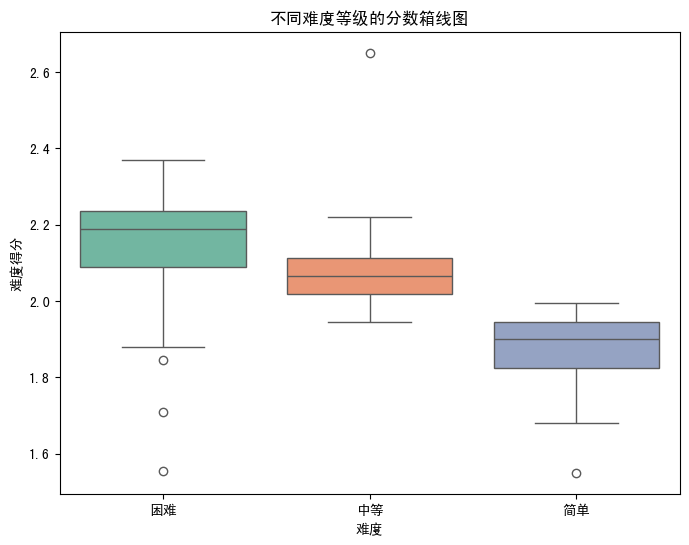

In [313]:
box_data = pd.DataFrame({
    "score": scores,
    "cluster": labels+1
})

# 绘制箱型图
plt.figure(figsize=(8, 6))
sns.boxplot(x="cluster", y="score", data=box_data, palette="Set2")

# 设置标题和标签
plt.title("不同难度等级的分数箱线图")
plt.xlabel("难度")
plt.ylabel("难度得分")
plt.xticks([0,1,2],['困难','中等','简单'])
# 显示图形
plt.savefig('不同难度等级的分数箱线图.png')
plt.show()


In [405]:
# 计算每个聚类的中位数和四分位距（箱体长度）
cluster_stats = box_data.groupby("cluster")["score"].agg(
    median="median",
    q1=lambda x: np.percentile(x, 25),
    q3=lambda x: np.percentile(x, 75)
)

# 计算箱体长度
cluster_stats["box_length"] = cluster_stats["q3"] - cluster_stats["q1"]

# 计算中位数之差
median_diff = cluster_stats["median"].max() - cluster_stats["median"].min()

# 计算箱体长度之差
box_length_diff = cluster_stats["box_length"].max() - cluster_stats["box_length"].min()

print(f"中位数之差: {median_diff}")
print(f"箱体长度之差: {box_length_diff}")


中位数之差: 0.2875000000000001
箱体长度之差: 0.05374999999999952


In [407]:
# 预测新样本的类别
predicted_label = kmeans.predict(try_pred.reshape(1,-1))

print(f"新样本的预测类别: {predicted_label[0]+1}")

新样本的预测类别: 1


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


In [375]:
sorted_data = data.sort_values('scores',inplace = False)
sorted_data = sorted_data.reset_index()

In [425]:
print( sorted_data[sorted_data['scores'] > 1.64 ])

# print(sorted_data[sorted_data['scores'] == 2.295])


     index  Unnamed: 0       Date  Contest number   Word  \
2      266         266 2022-04-09             294  stair   
3      253         253 2022-04-22             307  plant   
4       12          12 2022-12-19             548  slate   
5      246         246 2022-04-29             314  trash   
6      346         346 2022-01-19             214  point   
..     ...         ...        ...             ...    ...   
354    244         244 2022-05-01             316  forgo   
355    196         196 2022-06-18             364  cacao   
356    110         110 2022-09-12             450  booze   
357    178         178 2022-07-06             382  fluff   
358    279         279 2022-03-27             281  nymph   

     Number of  reported results  Number in hard mode  1 try  2 tries  \
2                         134210                 8537      2       21   
3                         119232                 7731      2       19   
4                          26010                 2422      6

In [339]:
try_pred

array([ 0.45739252, 10.20620773, 26.68408788, 31.37112265, 20.16421145,
        9.27872807,  2.18509696])

In [355]:
eerie_score = 0
for j in range(5):
    eerie_score = eerie_score + ((j+1)*try_pred[j]/100)/2
eerie_score += (try_pred[-1]/100)/2
eerie_score

1.6470635821792854

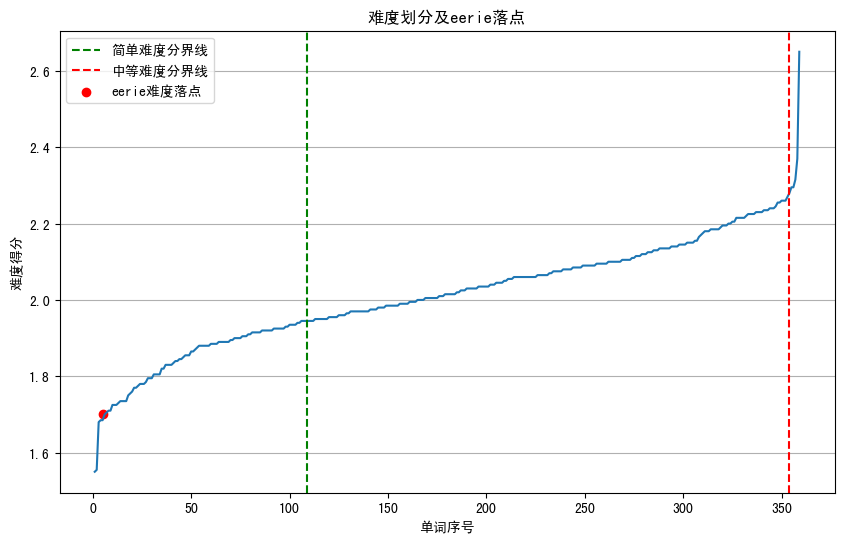

In [441]:
plt.figure(figsize = (10,6))
plt.plot(range(1,len(data)+1),sorted_data['scores'])
plt.axvline(x=109, color='green', linestyle='--', label='简单难度分界线')
plt.axvline(x=354, color='red', linestyle='--', label='中等难度分界线')
plt.scatter(5, 1.7, color='red',label = 'eerie难度落点')
plt.legend()
plt.xlabel('单词序号')
plt.ylabel('难度得分')
plt.grid(axis = 'y')
plt.title('难度划分及eerie落点')
plt.savefig('难度划分及eerie落点.png')
plt.show()

In [ ]:
def detect_and_correct_outliers(df, column_name):
    df = df.copy()

    median_value = df[column_name].median()
    
    #处理缺失值：替换为中位数
    df[column_name] = df[column_name].fillna(median_value)
    
    #处理负值：替换为0
    df.loc[df[column_name] < 0, column_name] = 0
    
    #IQR方法检测极值
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    #标记异常值
    df['is_outlier'] = (df[column_name] < lower_bound) | (df[column_name] > upper_bound)
    
    #修正极值：替换为中位数
    df.loc[df['is_outlier'], column_name] = median_value
    
    #确保修正后的值是整数
    df[column_name] = df[column_name].round().astype(int)
    
    return df